In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-11-03 13:31:52.738302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tm = yf.download('TM', start='2017-10-28', end='2022-10-28')
tm


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,124.250000,124.440002,124.070000,124.389999,124.389999,113500
2017-10-31,123.980003,124.139999,123.669998,124.000000,124.000000,110400
2017-11-01,124.290001,124.919998,124.180000,124.430000,124.430000,194200
2017-11-02,125.050003,125.489998,124.940002,125.309998,125.309998,153100
2017-11-03,125.510002,125.629997,125.019997,125.620003,125.620003,115300
...,...,...,...,...,...,...
2022-10-21,131.690002,133.919998,131.339996,133.759995,133.759995,313600
2022-10-24,133.630005,135.100006,133.139999,134.740005,134.740005,188300
2022-10-25,135.880005,137.910004,135.779999,137.070007,137.070007,193100


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

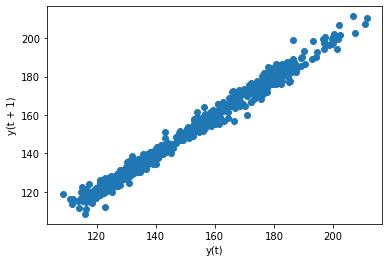

In [3]:
lag_plot(tm.Close)

In [ ]:
# to show correlation between two things, to see if it creates a linear trend 

mean : 142.93701903278006


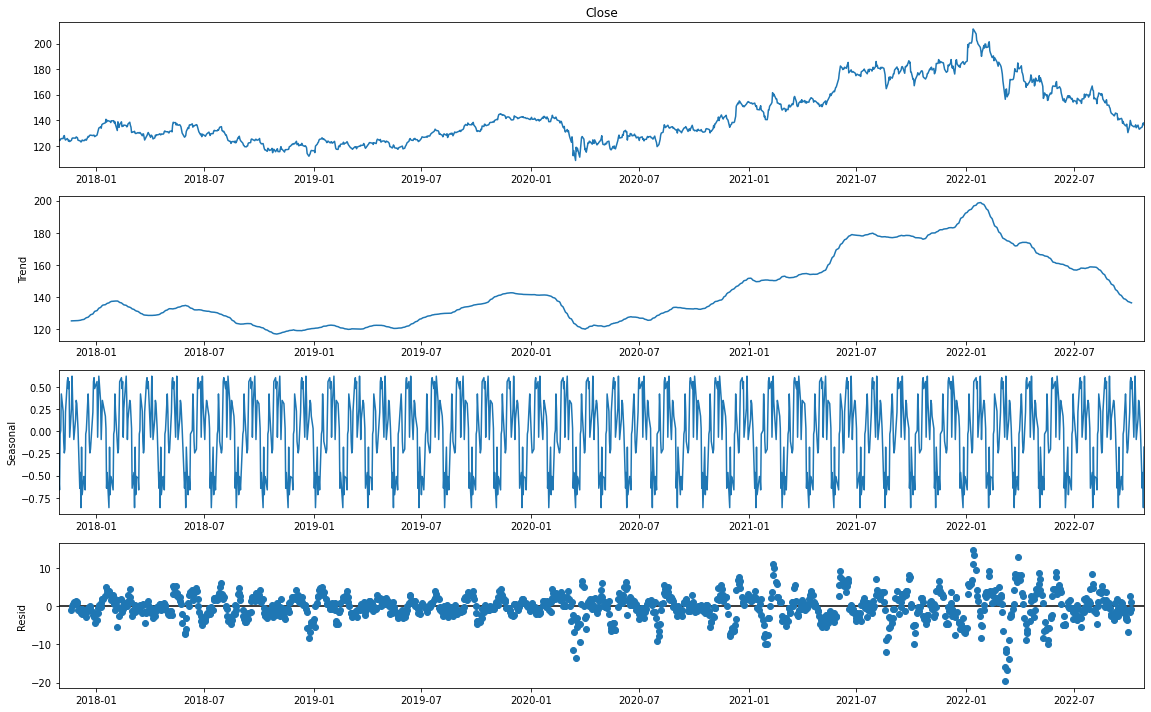

In [4]:
import statsmodels.api as sm
print('mean :' , tm.Close.mean())
res = sm.tsa.seasonal_decompose(tm.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

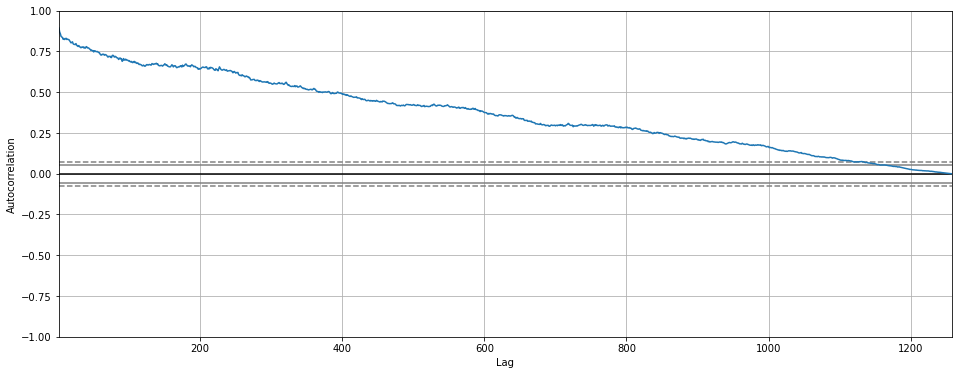

In [5]:
plt.figure(figsize=(16,6))
autocorrelation_plot(tm)

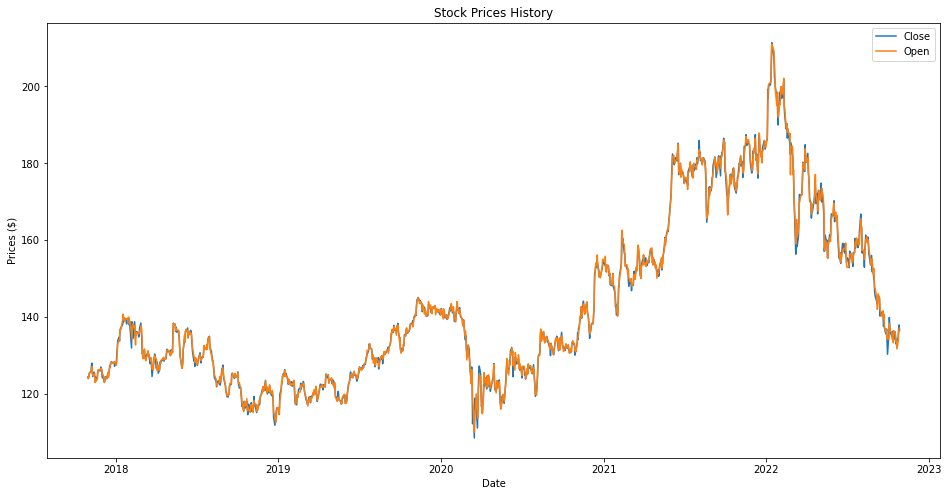

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(tm['Close'], label='Close')
plt.plot(tm['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

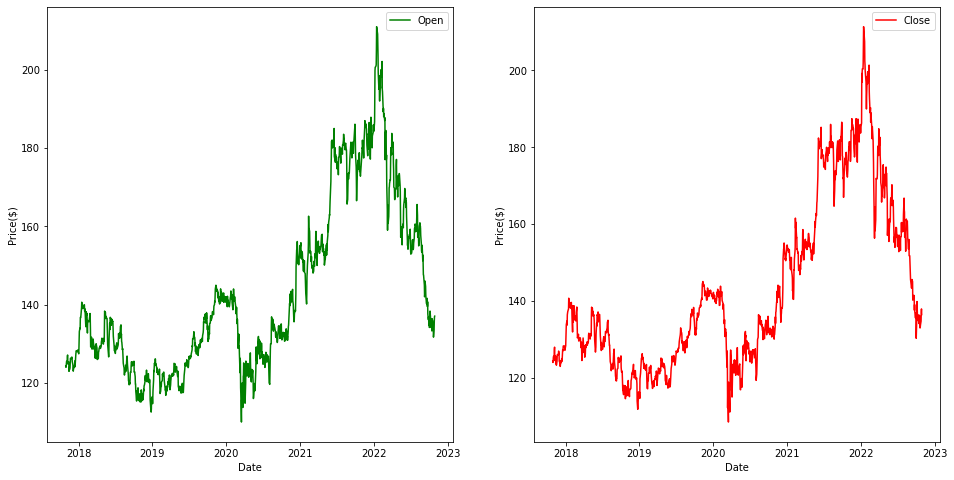

In [7]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(tm['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(tm['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [8]:
# 30 timesteps, 1 output, tried 30/60/365/750, 30/60 best performers 
# lstm model needs a 3d array input, so reshape to achieve this


close_prices = tm['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-30: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) # return=True so the output of the layer will be another sequence of the same length
model.add(Dropout(rate = 0.2))
model.add(layers.LSTM(100, return_sequences=False))# reture=false to only return the last output in the output sequence
model.add(Dropout(rate = 0.2))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
model.summary()

# tried with dropout and different layers/dense but this seemed to be the fastest 
# to run and had very similar results 

# this version has dropouts and a bigger first dense layer, plus a 60 day window, 
# results in  slightly worse rmse score

2022-11-03 13:32:02.838148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 126,301
Trainable params: 126,301
Non-trai

In [10]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 30, epochs=20)

Epoch 1/20
33/33 [==============================] - 4s 26ms/step - loss: 0.0094
Epoch 2/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0022
Epoch 3/20
33/33 [==============================] - 1s 30ms/step - loss: 0.0018
Epoch 4/20
33/33 [==============================] - 1s 32ms/step - loss: 0.0019
Epoch 5/20
33/33 [==============================] - 1s 30ms/step - loss: 0.0018
Epoch 6/20
33/33 [==============================] - 1s 35ms/step - loss: 0.0016
Epoch 7/20
33/33 [==============================] - 1s 37ms/step - loss: 0.0014
Epoch 8/20
33/33 [==============================] - 1s 31ms/step - loss: 0.0014
Epoch 9/20
33/33 [==============================] - 1s 37ms/step - loss: 0.0013
Epoch 10/20
33/33 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 11/20
33/33 [==============================] - 1s 32ms/step - loss: 0.0012
Epoch 12/20
33/33 [==============================] - 1s 35ms/step - loss: 0.0013
Epoch 13/20
33/33 [==================

In [11]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

# inverse transform to return actual value not scaled value 

8/8 [==============================] - 1s 12ms/step
CPU times: user 1.07 s, sys: 97.4 ms, total: 1.17 s
Wall time: 1.02 s


1.095831152927353

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


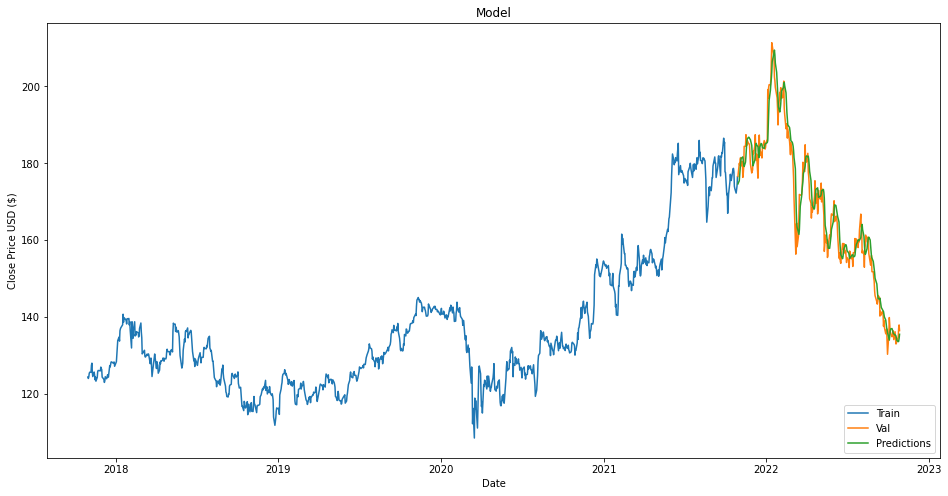

CPU times: user 540 ms, sys: 337 ms, total: 877 ms
Wall time: 916 ms


In [12]:
%%time
data = tm.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

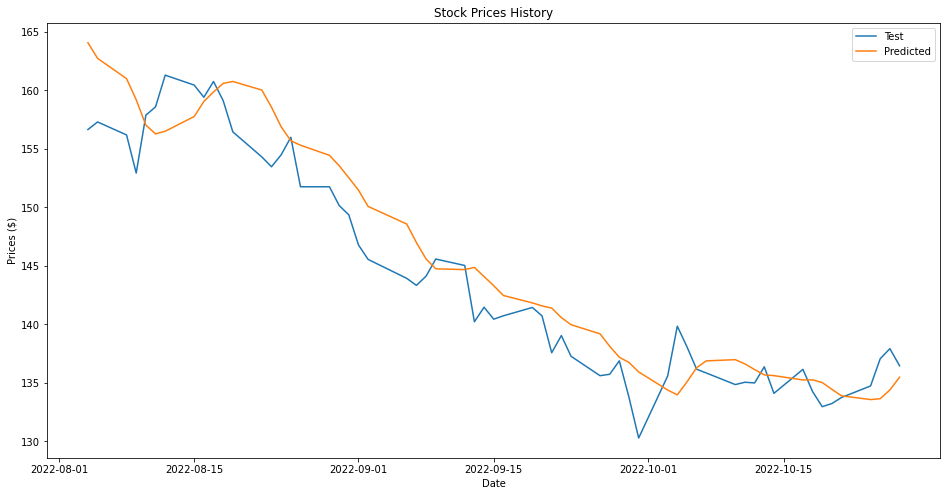

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(validation['Close'].iloc[-60:], label='Test')
plt.plot(validation['Predictions'].iloc[-60:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

In [14]:
from pandas import Timestamp
start = Timestamp('2022-10-28')
end = Timestamp('2022-11-03')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

,Value
Date,
2022-10-28,0
2022-10-29,0
2022-10-30,0
2022-10-31,0
2022-11-01,0
2022-11-02,0
2022-11-03,0


In [15]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

1/1 [==============================] - 1s 613ms/step


In [16]:
futurepredictions[0]

array([123.63667], dtype=float32)

In [17]:
# prediction a bit off but is the nature

In [18]:
# tm

In [19]:
testtm = tm.iloc[-251:]

In [20]:
testtm['predict'] = predictions

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_88991/3151535061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testtm['predict'] = predictions


In [21]:
testtm = testtm[['Close', 'predict']]
testtm

,Close,predict
Date,,
2021-10-29,176.570007,174.619583
2021-11-01,179.979996,175.445282
2021-11-02,179.610001,177.043549
2021-11-03,181.070007,178.551910
2021-11-04,181.479996,180.027237
...,...,...
2022-10-21,133.759995,133.897049
2022-10-24,134.740005,133.579025
2022-10-25,137.070007,133.651184


In [60]:
testtm['diff'] = testtm['predict'] - testtm['Close']
testtm.tail(30)

,Close,predict,diff
Date,,,
2022-09-16,140.740005,142.473999,1.733994
2022-09-19,141.449997,141.841339,0.391342
2022-09-20,140.729996,141.586960,0.856964
2022-09-21,137.580002,141.397522,3.817520
2022-09-22,139.050003,140.586472,1.536469
2022-09-23,137.279999,139.979462,2.699463
2022-09-26,135.619995,139.198944,3.578949
2022-09-27,135.740005,138.137344,2.397339
2022-09-28,136.889999,137.193161,0.303162


In [59]:
avgtest = testtm['diff'].mean()
avgtest

1.095831152927353

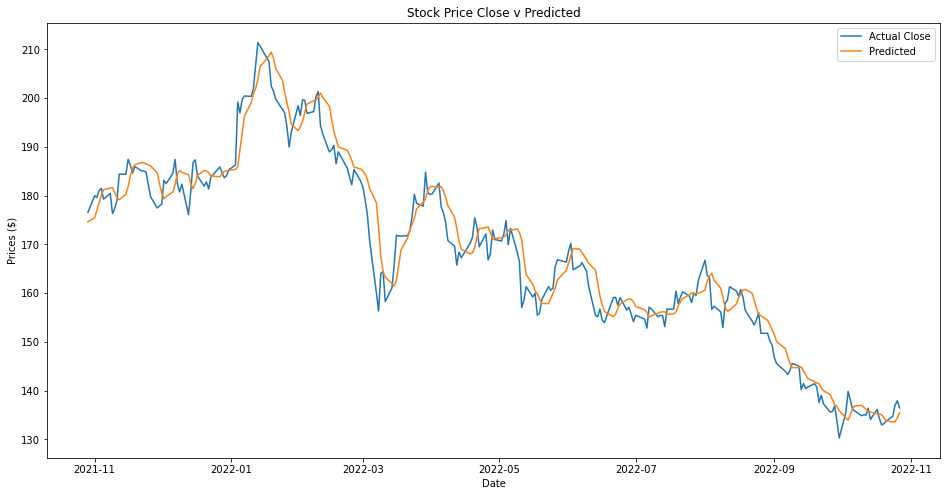

In [23]:
plt.figure(figsize=(16, 8))
plt.title('Stock Price Close v Predicted')
plt.plot(testtm['Close'], label='Actual Close')
plt.plot(testtm['predict'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

In [24]:
tsla = pd.read_csv('tslarealclose.csv')
tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-30,21.278667,21.585333,21.150000,21.338667,21.338667,63816000
1,2017-10-31,21.348667,22.129999,21.345333,22.101999,22.101999,85084500
2,2017-11-01,22.150000,22.174000,21.350668,21.405333,21.405333,126859500
3,2017-11-02,20.008667,20.579332,19.508667,19.950666,19.950666,296871000
4,2017-11-03,19.966667,20.416668,19.675333,20.406000,20.406000,133410000
...,...,...,...,...,...,...,...
1253,2022-10-21,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
1254,2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
1255,2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900
1256,2022-10-26,219.399994,230.600006,218.199997,224.639999,224.639999,85012500


In [25]:
tsla.Date = pd.to_datetime(tsla.Date)
tsla.index = pd.DatetimeIndex(tsla.Date, freq=None)
tsla

tsla = tsla.drop(['Date'],axis=1)
tsla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,21.278667,21.585333,21.150000,21.338667,21.338667,63816000
2017-10-31,21.348667,22.129999,21.345333,22.101999,22.101999,85084500
2017-11-01,22.150000,22.174000,21.350668,21.405333,21.405333,126859500
2017-11-02,20.008667,20.579332,19.508667,19.950666,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,20.406000,133410000
...,...,...,...,...,...,...
2022-10-21,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900


In [27]:
# TESLA TEST 

tsclose_prices = tsla['Close']
tsvalues = tsclose_prices.values
tstraining_data_len = math.ceil(len(tsvalues)* 0.8)

# scaler = MinMaxScaler(feature_range=(0,1))
tsscaled_data = scaler.transform(tsvalues.reshape(-1,1))

# train_data = scaled_data[0: training_data_len, :]

# x_train = []
# y_train = []

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i, 0])
#     y_train.append(train_data[i, 0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


tstest_data = tsscaled_data[tstraining_data_len-60: , : ]
tsx_test = []
tsy_test = tsvalues[tstraining_data_len:]

for i in range(60, len(tstest_data)):
    tsx_test.append(tstest_data[i-60:i, 0])

tsx_test = np.array(tsx_test)
tsx_test = np.reshape(tsx_test, (tsx_test.shape[0], tsx_test.shape[1], 1))

In [28]:
# tsx_test

In [29]:
%%time
tpredictions = model.predict(tsx_test)
tpredictions = scaler.inverse_transform(tpredictions)
trmse = np.sqrt(np.mean(tpredictions - tsy_test)**2)
trmse


8/8 [==============================] - 1s 18ms/step
CPU times: user 958 ms, sys: 128 ms, total: 1.09 s
Wall time: 788 ms


1.6259788725955553

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


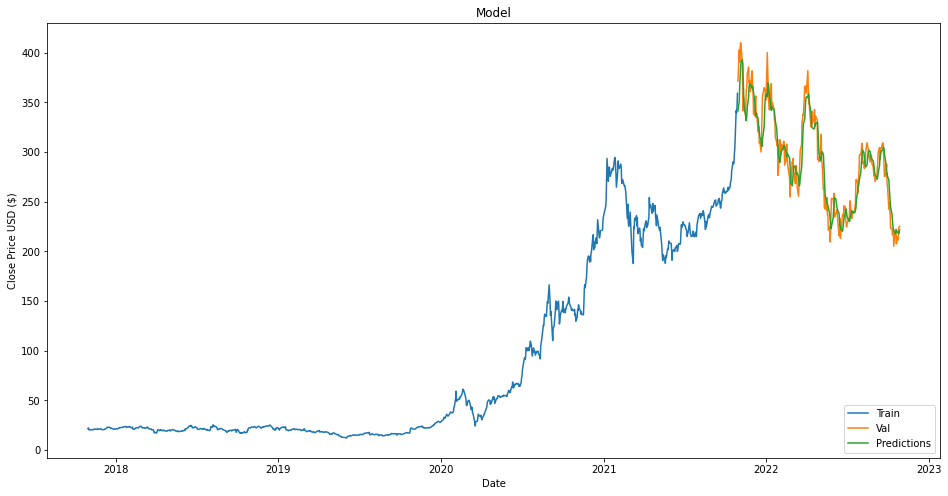

CPU times: user 219 ms, sys: 12.3 ms, total: 231 ms
Wall time: 295 ms


In [30]:
%%time
tdata = tsla.filter(['Close'])
ttrain = tdata[:tstraining_data_len]
tvalidation = tdata[tstraining_data_len:]
tvalidation['Predictions'] = tpredictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(ttrain)
plt.plot(tvalidation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [31]:
goog = pd.read_csv('googrealclose.csv')
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-30,50.700001,51.248501,50.375000,50.855499,50.855499,41702000
1,2017-10-31,50.761002,51.200001,50.521000,50.832001,50.832001,26614000
2,2017-11-01,50.860500,51.483501,50.847500,51.275002,51.275002,27468000
3,2017-11-02,51.088001,51.404499,50.650501,51.278999,51.278999,20980000
4,2017-11-03,51.105499,51.632500,51.015499,51.624001,51.624001,21528000
...,...,...,...,...,...,...,...
1253,2022-10-21,98.459999,101.620003,98.230003,101.480003,101.480003,28976000
1254,2022-10-24,102.089996,103.099998,100.300003,102.970001,102.970001,24680800
1255,2022-10-25,103.300003,105.099998,103.019997,104.930000,104.930000,29910200
1256,2022-10-26,96.760002,98.540001,94.570000,94.820000,94.820000,71504300


In [32]:
goog.Date = pd.to_datetime(goog.Date)
goog.index = pd.DatetimeIndex(goog.Date, freq=None)
goog

goog = goog.drop(['Date'],axis=1)
goog

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,50.700001,51.248501,50.375000,50.855499,50.855499,41702000
2017-10-31,50.761002,51.200001,50.521000,50.832001,50.832001,26614000
2017-11-01,50.860500,51.483501,50.847500,51.275002,51.275002,27468000
2017-11-02,51.088001,51.404499,50.650501,51.278999,51.278999,20980000
2017-11-03,51.105499,51.632500,51.015499,51.624001,51.624001,21528000
...,...,...,...,...,...,...
2022-10-21,98.459999,101.620003,98.230003,101.480003,101.480003,28976000
2022-10-24,102.089996,103.099998,100.300003,102.970001,102.970001,24680800
2022-10-25,103.300003,105.099998,103.019997,104.930000,104.930000,29910200


In [33]:
# GOOGLE TEST 

gclose_prices = goog['Close']
gvalues = gclose_prices.values
gtraining_data_len = math.ceil(len(gvalues)* 0.8)

# scaler = MinMaxScaler(feature_range=(0,1))
gscaled_data = scaler.transform(gvalues.reshape(-1,1))

# train_data = scaled_data[0: training_data_len, :]

# x_train = []
# y_train = []

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i, 0])
#     y_train.append(train_data[i, 0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


gtest_data = gscaled_data[gtraining_data_len-60: , : ]
gx_test = []
gy_test = gvalues[gtraining_data_len:]

for i in range(60, len(gtest_data)):
    gx_test.append(gtest_data[i-60:i, 0])

gx_test = np.array(gx_test)
gx_test = np.reshape(gx_test, (gx_test.shape[0], gx_test.shape[1], 1))

In [34]:
# gx_test

In [35]:
%%time
gpredictions = model.predict(gx_test)
gpredictions = scaler.inverse_transform(gpredictions)
grmse = np.sqrt(np.mean(gpredictions - gy_test)**2)
grmse


8/8 [==============================] - 0s 19ms/step
CPU times: user 592 ms, sys: 111 ms, total: 703 ms
Wall time: 430 ms


0.0034808884578872014

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


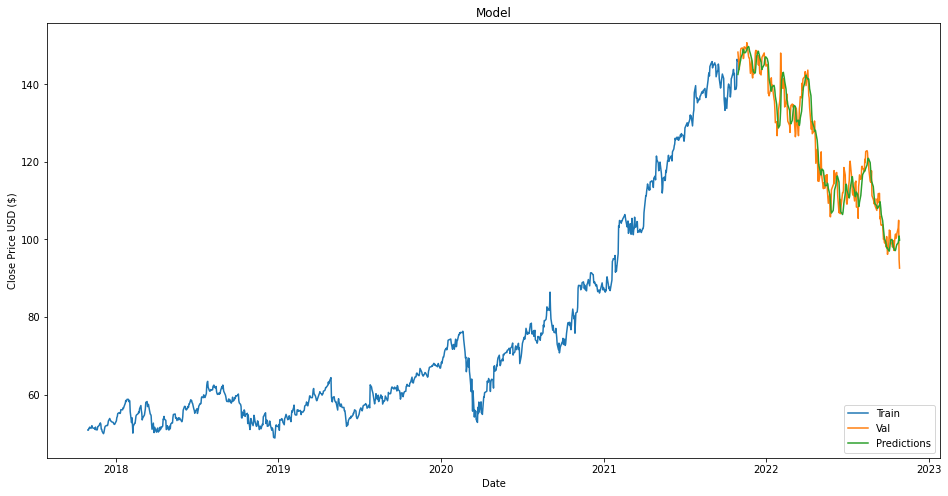

CPU times: user 187 ms, sys: 10.5 ms, total: 198 ms
Wall time: 200 ms


In [36]:
%%time
gdata = goog.filter(['Close'])
gtrain = gdata[:gtraining_data_len]
gvalidation = gdata[gtraining_data_len:]
gvalidation['Predictions'] = gpredictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(gtrain)
plt.plot(gvalidation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [37]:
aapl = pd.read_csv('aaplrealclose.csv')
aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-30,40.972500,42.017502,40.930000,41.680000,39.557045,178803200
1,2017-10-31,41.974998,42.412498,41.735001,42.259998,40.107510,144187200
2,2017-11-01,42.467499,42.485001,41.402500,41.722500,39.597370,134551200
3,2017-11-02,41.650002,42.125000,41.320000,42.027500,39.886833,165573600
4,2017-11-03,43.500000,43.564999,42.779999,43.125000,40.928436,237594400
...,...,...,...,...,...,...,...
1253,2022-10-21,142.869995,147.850006,142.649994,147.270004,147.270004,86464700
1254,2022-10-24,147.190002,150.229996,146.000000,149.449997,149.449997,75981900
1255,2022-10-25,150.089996,152.490005,149.360001,152.339996,152.339996,74732300
1256,2022-10-26,150.960007,151.990005,148.039993,149.350006,149.350006,88194300


In [38]:
aapl.Date = pd.to_datetime(aapl.Date)
aapl.index = pd.DatetimeIndex(aapl.Date, freq=None)
aapl

aapl = aapl.drop(['Date'],axis=1)
aapl

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,40.972500,42.017502,40.930000,41.680000,39.557045,178803200
2017-10-31,41.974998,42.412498,41.735001,42.259998,40.107510,144187200
2017-11-01,42.467499,42.485001,41.402500,41.722500,39.597370,134551200
2017-11-02,41.650002,42.125000,41.320000,42.027500,39.886833,165573600
2017-11-03,43.500000,43.564999,42.779999,43.125000,40.928436,237594400
...,...,...,...,...,...,...
2022-10-21,142.869995,147.850006,142.649994,147.270004,147.270004,86464700
2022-10-24,147.190002,150.229996,146.000000,149.449997,149.449997,75981900
2022-10-25,150.089996,152.490005,149.360001,152.339996,152.339996,74732300


In [39]:
# APPLE TEST 

aclose_prices = aapl['Close']
avalues = aclose_prices.values
atraining_data_len = math.ceil(len(avalues)* 0.8)

# scaler = MinMaxScaler(feature_range=(0,1))
ascaled_data = scaler.transform(avalues.reshape(-1,1))

# train_data = scaled_data[0: training_data_len, :]

# x_train = []
# y_train = []

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i, 0])
#     y_train.append(train_data[i, 0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


atest_data = ascaled_data[atraining_data_len-60: , : ]
ax_test = []
ay_test = avalues[atraining_data_len:]

for i in range(60, len(atest_data)):
    ax_test.append(atest_data[i-60:i, 0])

ax_test = np.array(ax_test)
ax_test = np.reshape(ax_test, (ax_test.shape[0], ax_test.shape[1], 1))

In [40]:
%%time
apredictions = model.predict(ax_test)
apredictions = scaler.inverse_transform(apredictions)
armse = np.sqrt(np.mean(apredictions - ay_test)**2)
armse


8/8 [==============================] - 0s 20ms/step
CPU times: user 414 ms, sys: 114 ms, total: 528 ms
Wall time: 222 ms


0.513918264928567

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


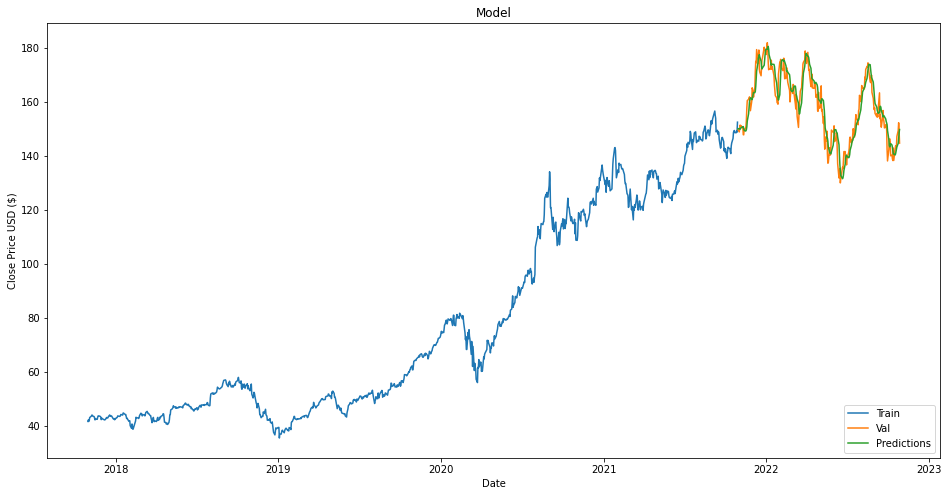

CPU times: user 190 ms, sys: 10 ms, total: 200 ms
Wall time: 200 ms


In [41]:
%%time
adata = aapl.filter(['Close'])
atrain = adata[:atraining_data_len]
avalidation = adata[atraining_data_len:]
avalidation['Predictions'] = apredictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(atrain)
plt.plot(avalidation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [42]:
nflx = pd.read_csv('nflxrealclose.csv')
nflx

nflx.Date = pd.to_datetime(nflx.Date)
nflx.index = pd.DatetimeIndex(nflx.Date, freq=None)
nflx

nflx = nflx.drop(['Date'],axis=1)
nflx

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,199.619995,201.100006,197.070007,198.369995,198.369995,5439600
2017-10-31,198.210007,198.589996,195.220001,196.429993,196.429993,5518600
2017-11-01,197.240005,199.199997,196.000000,198.000000,198.000000,5017400
2017-11-02,197.449997,199.440002,197.089996,199.320007,199.320007,3606300
2017-11-03,199.800003,200.550003,197.990005,200.009995,200.009995,3678800
...,...,...,...,...,...,...
2022-10-21,268.950012,290.750000,265.679993,289.570007,289.570007,24862700
2022-10-24,290.230011,290.489990,280.359985,282.450012,282.450012,13326400
2022-10-25,286.950012,297.589996,285.549988,291.019989,291.019989,15100700


In [43]:
# NETFLIX TEST 

nclose_prices = nflx['Close']
nvalues = nclose_prices.values
ntraining_data_len = math.ceil(len(nvalues)* 0.8)

nscaled_data = scaler.transform(nvalues.reshape(-1,1))


ntest_data = nscaled_data[ntraining_data_len-60: , : ]
nx_test = []
ny_test = nvalues[ntraining_data_len:]

for i in range(60, len(ntest_data)):
    nx_test.append(ntest_data[i-60:i, 0])

nx_test = np.array(nx_test)
nx_test = np.reshape(nx_test, (nx_test.shape[0], nx_test.shape[1], 1))

In [44]:
%%time
npredictions = model.predict(nx_test)
npredictions = scaler.inverse_transform(npredictions)
nrmse = np.sqrt(np.mean(npredictions - ny_test)**2)
nrmse


8/8 [==============================] - 0s 18ms/step
CPU times: user 386 ms, sys: 106 ms, total: 492 ms
Wall time: 201 ms


14.302008153907806

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


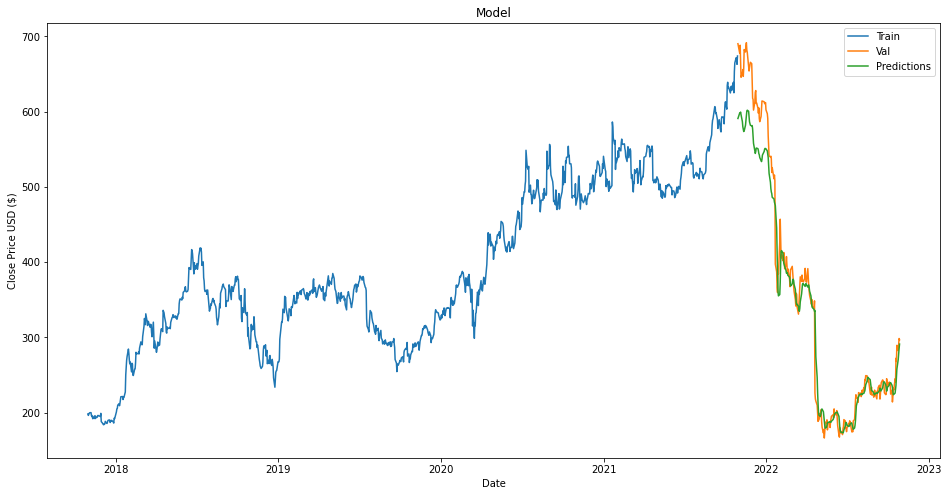

CPU times: user 190 ms, sys: 10.4 ms, total: 201 ms
Wall time: 201 ms


In [45]:
%%time
ndata = nflx.filter(['Close'])
ntrain = ndata[:ntraining_data_len]
nvalidation = ndata[ntraining_data_len:]
nvalidation['Predictions'] = npredictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(ntrain)
plt.plot(nvalidation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

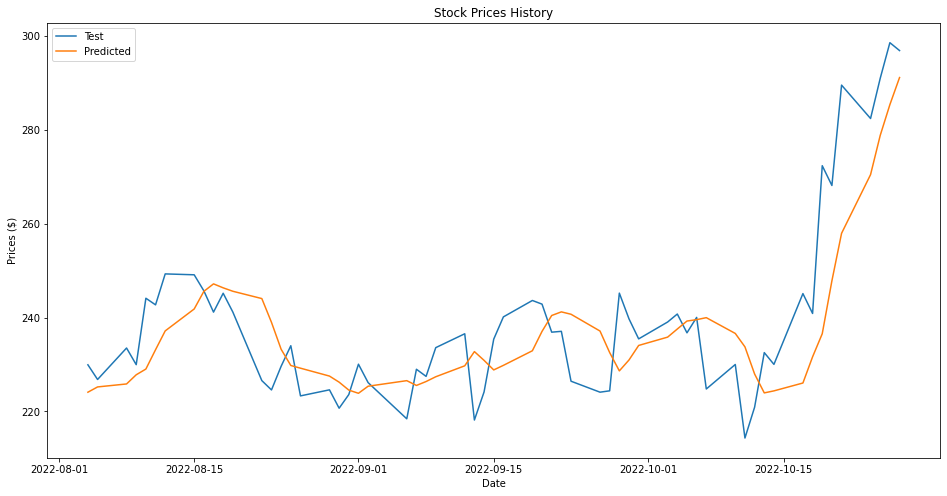

In [46]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(nvalidation['Close'].iloc[-60:], label='Test')
plt.plot(nvalidation['Predictions'].iloc[-60:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

In [47]:
display = nflx.iloc[-251:]

In [48]:
display['predict'] = npredictions

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_88991/257892983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['predict'] = npredictions


In [49]:
display = display[['Close', 'predict']]
display

,Close,predict
Date,,
2021-10-29,690.309998,590.955566
2021-11-01,681.169983,596.120728
2021-11-02,677.719971,598.248352
2021-11-03,688.289978,598.016602
2021-11-04,668.400024,599.464661
...,...,...
2022-10-21,289.570007,257.959076
2022-10-24,282.450012,270.474609
2022-10-25,291.019989,278.843506


In [50]:
display['diff'] = display['predict'] - display['Close']
display

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_88991/407356775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['diff'] = display['predict'] - display['Close']


,Close,predict,diff
Date,,,
2021-10-29,690.309998,590.955566,-99.354431
2021-11-01,681.169983,596.120728,-85.049255
2021-11-02,677.719971,598.248352,-79.471619
2021-11-03,688.289978,598.016602,-90.273376
2021-11-04,668.400024,599.464661,-68.935364
...,...,...,...
2022-10-21,289.570007,257.959076,-31.610931
2022-10-24,282.450012,270.474609,-11.975403
2022-10-25,291.019989,278.843506,-12.176483


In [54]:
def testmodel(df):

    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaled_data = scaler.transform(values.reshape(-1,1))
    
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print(rmse)
    
    
    
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'])
    plt.show()

In [55]:
qcom = yf.download('QCOM', start='2017-10-28', end='2022-10-28')
qcom


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,54.160000,54.770000,54.080002,54.660000,47.421841,7081500
2017-10-31,52.259998,52.490002,50.020000,51.009998,44.255180,29914100
2017-11-01,51.470001,53.490002,50.509998,53.459999,46.380749,15624400
2017-11-02,53.599998,55.680000,53.599998,54.840000,47.578007,17337800
2017-11-03,54.759998,64.989998,54.209999,61.810001,53.625031,80964500
...,...,...,...,...,...,...
2022-10-21,111.750000,115.989998,111.019997,115.739998,115.739998,7488100
2022-10-24,116.339996,117.019997,114.239998,116.379997,116.379997,6525700
2022-10-25,116.570000,119.940002,116.230003,119.169998,119.169998,6205100


8/8 [==============================] - 0s 17ms/step
0.37422371670544385


/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_88991/3420088020.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


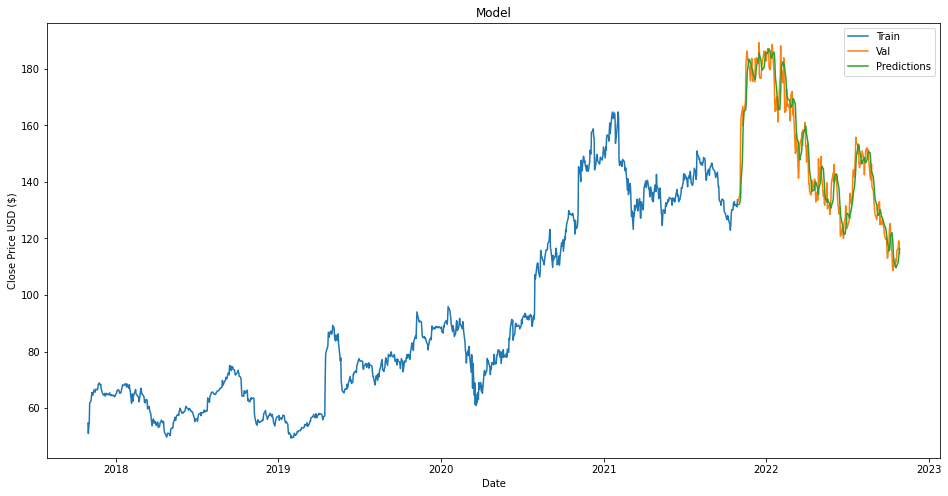

CPU times: user 586 ms, sys: 188 ms, total: 774 ms
Wall time: 563 ms


In [56]:
%%time
testmodel(qcom)

In [ ]:
# qcom ticker is totally new information, not used in any other drafts or tests, just to see if model is good 

In [ ]:
# i think this is about as good as it gets model terms

In [ ]:
# toyota mdoel is based on a less volatile stock than tesla/nflx, 
# this could explain differences in models accuracy based on these stocks

In [ ]:
# what could do in future? test models against more stocks 

In [ ]:
# why 60 day window or 30 day ?
# 30 day window allows for maximum train data, accuracy went down 